<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
from itertools import count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Policy network

This is the fully connected policy network, we will use in the REINFORCE algorithm:

In [ ]:
class PolicyNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):

    super(PolicyNetwork, self).__init__()

    # set the activation fct for the fully connected layer
    self.activation_fc = activation_fc

    # the input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    # the hidden layers
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # the output layer
    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)

    return x

  def forward(self, state):
    '''
    Define the forward pass.
    '''
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))

    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    return self.output_layer(x)

  def full_pass(self, state):
    # perform the forward pass to obtain the logits (preferences over the actions)
    # logits are interpreted to be the unnormalized (or not yet normalized) predictions
    # (or outputs) of a model
    logits = self.forward(state)

    # create a probability distribution using the logits
    dist = torch.distributions.Categorical(logits=logits)

    # sample an action from the probability distribution
    action = dist.sample()

    # get the log probabilities of the selected action
    logpa = dist.log_prob(action).unsqueeze(-1)

    # return the selected action and its log probability
    return action.item(), logpa


  def select_action(self, state):
    '''
    Sample an action from the probability distribution.
    '''
    logits = self.forward(state)
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    return action.item()

  def select_greedy_action(self, state):
    '''
    Select a greedy action according to the policy.
    '''
    logits = self.forward(state)
    return np.argmax(logits.detach().numpy())

# REINFORCE

The REINFORCE is the simplest policy-gradient algorithm. This algorithm tries to increase the log probability of all actions in a trajectory, proportional to the goodness of the full return (Monte-Carlo return). So, basically, it first collects a full trajectory, calculate the full discounted return and then use that score to weight the log probabilities of every action take in that trajectory.

The gradient we are trying to estimate is the following one:

$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[\sum_{t=0}^T G_t(\tau)\nabla_\theta log(\pi_\theta(A_t|S_t))]$

whereas:



*   $\tau \sim \pi_\theta$ means "sample a trajectory $\tau$"
*   $\sum_{t=0}^T G_t(\tau)$ means "for each timestep t in the trajectory $\tau$, calculate the full return from that step"
*   $log(\pi_\theta(A_t|S_t)$ is the log probability of action $A$ taken at time step t given the state $S$ at time step t

As mentioned above, we use the full return $G_t$ as the score to weight the log probability of the action taken at time step t.



In [ ]:
class REINFORCE():

  def __init__(self,
               env,
               model,
               optimizer,
               gamma,
               max_episodes = 10000,
               max_minutes=10,
               goal_mean_reward=475):
    self.env = env
    self.model = model
    self.optimizer = optimizer
    self.gamma = gamma
    self.max_episodes = max_episodes
    self.max_minutes = max_minutes
    self.goal_mean_100_reward = goal_mean_100_reward
    self.evaluation_scores = []


  def interaction(self, state):
    '''
    Perform the interaction with environment
    '''

    # pass the state through the policy network to
    # sample an action from the probability distribution and
    # also get the log probability of the selected action
    action, logpa = self.model.full_pass(state)

    # take the action in the environment
    next_state, reward, is_terminal, _ = self.env.step(action)

    # store the log probability of the action
    self.logpas.append(logpa)

    # store the experienced reward we get after taking the action
    self.rewards.append(reward)


    return next_state, is_terminal


  def optimize(self):
    '''
    Optimize the policy network.
    '''

    # compute the number of rewards
    T = len(self.rewards)

    # compute the discounts for each reward
    discounts = np.logspace(0,
                            T,
                            num=T,
                            base=self.gamma,
                            endpoint=False)

    # compute the sum of the discounted returns for all time steps
    # this is the returns for every time step in the current episode
    # from the initial state at time step 0, to one before the terminal T-1
    returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])

    # convert the discounts and returns to float tensors
    discounts = torch.FloatTensor(discounts).unsqueeze(1)
    returns = torch.FloatTensor(returns).unsqueeze(1)

    # concatenate the list of log probabilities
    self.logpas = torch.cat(self.logpas)

    # now, compute the loss of the policy network
    # note that we discount the returns; this extra discount assumes
    # that we are trying to optimize the expect discounted return
    # from the initial state, so the returns later in an episode get
    # discounted
    # we also add a minus sign because PyTorch performs gradient descent by default
    # since we want to maximize the performance objective we take the negative mean of
    # the objective to flip it; as a result, the probability of "good" actions will be
    # increased and the probability of "bad" actions will be decreased
    # last but not least, we also account for discounted policy gradients, so we multiply
    # the returns by the discounts
    loss = -(discounts * returns * self.logpas).mean()

    # zero-out the gradients
    self.optimizer.zero_grad()

    # compute the gradients
    loss.backward()

    # update the weights
    self.optimizer.step()


  def train(self):

    # get the starting time of the training phase
    training_start = time.time()

    # for each episode do the following
    for episode in range(1, self.max_episodes + 1):

      # get the initial state
      state = self.env.reset()

      # is_terminal flag to indicate whether an episode is finished
      is_terminal = False

      self.logpas = []
      self.rewards = []

      # for each time step in the current episode
      for timestep in count():

        # interact with the environment
        state, is_terminal = self.interaction(state)

        # finish current episode if a terminal state is reached
        if is_terminal:
          break


      # after episode is finished, optimize the model
      self.optimize()

      # compute the evaluation score
      evaluation_score = self.evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)


      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      wallclock_elapsed = time.time() - training_start
      reached_max_minutes = wallclock_elapsed >= self.max_minutes * 60
      reached_max_episodes = episode >= self.max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward

      training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

      if training_is_over:
        if reached_max_minutes: print('Max minutes are reached')
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break


    final_evaluation_score = self.evaluate(episodes=100)
    print(f"Final_evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

    return final_evaluation_score

  def evaluate(self, episodes=1, greedy=True):
    ''' Evaluate the model. '''

    # keep track of the rewards
    rewards = []

    # for each episode (default: 1) do the following
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset()
      # set is_terminal flag to False
      is_terminal = False

      # append a 0 to rewards list
      rewards.append(0)

      # for each timestep of the current episode, do the following
      for _ in count():
        if greedy:
          # select a greedy action according to the policy.
          action = self.model.select_greedy_action(state)
        else:
          # sample an action from the distribution
          action = self.model.select_action(state)

        # take the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)

        # save the reward
        rewards[-1] += reward

        # finish when terminal state is reached
        if is_terminal:
          break

    # return the mean of the rewards to the caller
    return np.mean(rewards)

Let's train our REINFORCE agent:

In [ ]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
SEEDS = (12, 34, 56, 78, 90)

# we let five DQN agents train, the one with the best evaluation score will be selected as the best one
# in each iteration, a different seed is used for creating the environment
for seed in SEEDS:
  # create an instance of the environment
  env = gym.make("CartPole-v1")
  env.seed(seed)

  # obtain the number of variables used in each state and the number of actions
  nS, nA = env.observation_space.shape[0], env.action_space.n

  # build the online network
  model = PolicyNetwork(nS, nA, hidden_dims=(128,64))

  # create an instance of the RMSprop optimizer
  lr = 0.0005
  optimizer = optim.Adam(model.parameters(), lr=lr)

  # define the our discount factor
  gamma = 1.00

  # define max minutes
  max_minutes = 10

  # define nr. of max episodes
  max_episodes = 10000

  # define mean reward value
  goal_mean_100_reward = 475

  # create the DQN agent
  agent = REINFORCE(env,
                    model,
                    optimizer,
                    gamma,
                    max_episodes,
                    max_minutes,
                    goal_mean_100_reward,
                    )

  # let the DQN agent train
  final_evaluation_score = agent.train()

  if final_evaluation_score > best_eval_score:
    best_eval_score = final_evaluation_score
    best_agent = agent

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 417.79
Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0


# Save model

In [ ]:
torch.save(best_agent.model.state_dict(), "/content/drive/MyDrive/REINFORCE/REINFORCE_agent_final.pt")

# Visualization

In [ ]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [ ]:
env = gym.make("CartPole-v1")
model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(128,64))
model.load_state_dict(torch.load("/content/drive/MyDrive/REINFORCE/REINFORCE_agent_final.pt"))
model.eval()

PolicyNetwork(
  (input_layer): Linear(in_features=4, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):

      # select an action from the probability distribution
      action = model.select_action(state)

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'REINFORCE_agent.gif'), frames, fps=60)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


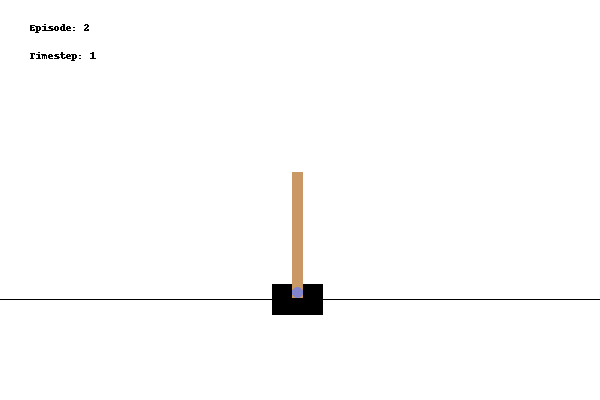

In [ ]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/REINFORCE_agent.gif','rb').read())